In [1]:
#Mission: It is your job to predict if a passenger survived the sinking of the Titanic or not. For each PassengerId in the test set, you must predict a 0 or 1 value for the Survived variable.
#Evaluation: Your score is the percentage of passengers you correctly predict. This is known simply as "accuracy”.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [2]:
#data を取得
df_train = pd.read_csv('titanic_train.csv')
df_test = pd.read_csv('titanic_test.csv')

In [4]:
#欠損値の状況を把握
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
Fare,0,0.000000
Ticket,0,0.000000


/Users/tanakamarunatsurou/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


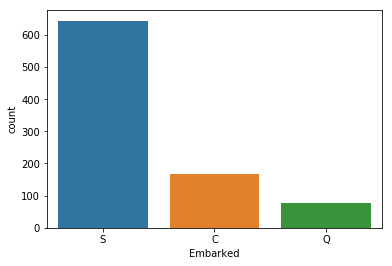

In [5]:
#Cabinは削除
df_train = df_train.drop(['Cabin'], axis=1)

#Embarked,二個だけなので最も多い値を入れとく
sns.countplot(x='Embarked', data=df_train)

In [6]:
df_train["Embarked"] = df_train["Embarked"].fillna("S")

#イニシャルから、age予測
df_train['Initial']=0
for i in df_train:
    df_train['Initial']=df_train.Name.str.extract('([A-Za-z]+)\.')


pd.crosstab(df_train.Initial,df_train.Sex).T.style.background_gradient(cmap='summer_r')

/Users/tanakamarunatsurou/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [7]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

df_train.groupby('Initial')['Age'].mean() 

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

In [8]:
#Age補充
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age']=33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age']=36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age']=5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age']=22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age']=46

In [10]:
#欠損値処理完了
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
Initial,0,0.0
Embarked,0,0.0
Fare,0,0.0
Ticket,0,0.0
Parch,0,0.0


In [11]:
#カテゴリデータ(Name,Sex,Ticket,Embarked,Initial)の処理
#関係なさそうなやつは削除
df_train = df_train.drop(['PassengerId','Name','Ticket'], axis=1)

#SEX
df_train = df_train.replace("male",0).replace("female",1)

In [13]:
#Family sizeを錬成
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_train = df_train.drop(['SibSp','Parch'], axis=1)

In [14]:
#Initial
df_train = df_train.replace("Mr",0).replace("Mrs",1).replace("Miss",2).replace("Master",3).replace("Mrs",4).replace("Other",5)

In [16]:
#Embarked
df_train = df_train.replace("C",0).replace("Q",1).replace("S",2)

In [20]:
df_train.corr()

,Survived,Pclass,Sex,Age,Fare,Embarked,Initial,FamilySize
Survived,1.000000,-0.338481,0.543351,-0.091497,0.257307,-0.167675,0.404692,0.016639
Pclass,-0.338481,1.000000,-0.131900,-0.339582,-0.549500,0.162098,-0.052941,0.065997
Sex,0.543351,-0.131900,1.000000,-0.120417,0.182333,-0.108262,0.599417,0.200988
Age,-0.091497,-0.339582,-0.120417,1.000000,0.089087,-0.024008,-0.365029,-0.282260
Fare,0.257307,-0.549500,0.182333,0.089087,1.000000,-0.224719,0.125180,0.217138
Embarked,-0.167675,0.162098,-0.108262,-0.024008,-0.224719,1.000000,-0.063137,0.066516
Initial,0.404692,-0.052941,0.599417,-0.365029,0.125180,-0.063137,1.000000,0.336627
FamilySize,0.016639,0.065997,0.200988,-0.282260,0.217138,0.066516,0.336627,1.000000


In [21]:
#上級の客の方が、生き残ってるぽい
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [22]:
#女性の方が生き残ってる
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,0,0.188908
1,1,0.742038


In [25]:
#相関なさげ
df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,0,0.553571
1,1,0.389610
2,2,0.339009


In [26]:
#Mrs,Miss>Master>Mr,Other,女性や子供ほど生き残る
df_train[['Initial', 'Survived']].groupby(['Initial'], as_index=False).mean()

,Initial,Survived
0,0,0.162571
1,1,0.795276
2,2,0.704301
3,3,0.575000
4,5,0.111111


In [28]:
#少人数の方が生き残る,but3>2>1
df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean()

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


/Users/tanakamarunatsurou/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


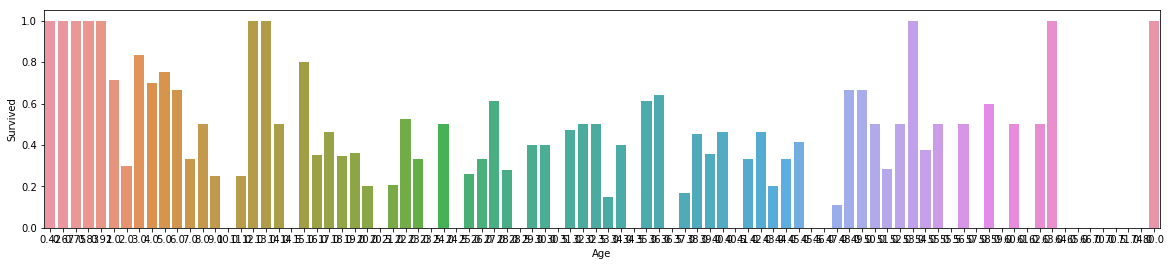

In [31]:
#若年層が生き残る
fig, axis1 = plt.subplots(1,1,figsize=(20,4))
average_age = df_train[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)

/Users/tanakamarunatsurou/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


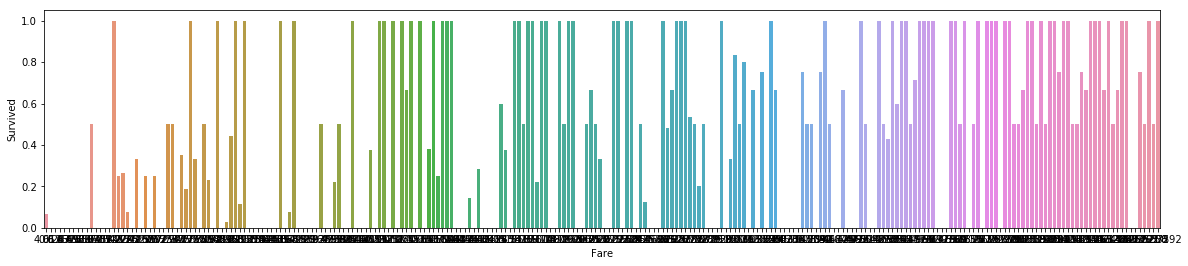

In [32]:
#相関なさげ
fig, axis1 = plt.subplots(1,1,figsize=(20,4))
average_age = df_train[["Fare", "Survived"]].groupby(['Fare'],as_index=False).mean()
sns.barplot(x='Fare', y='Survived', data=average_age)

In [59]:
#data1
df_train_pickup = df_train.loc[:,['Pclass','Sex','Initial','FamilySize','Age']]

X_1 = df_train_pickup.values
y_1 = df_train.loc[:,['Survived']].values
y_1 = y_1.reshape(-1)

In [58]:
#data2
df_train_pickup_2 = df_train.loc[:,['Pclass','Sex','Initial','FamilySize']]

X_2 = df_train_pickup_2.values
y_1 = df_train.loc[:,['Survived']].values
y_1 = y_1.reshape(-1)

In [69]:
#data3
df_train_pickup_3 = df_train.loc[:,['Pclass','Sex','Initial']]

X_3 = df_train_pickup_3.values
y_1 = df_train.loc[:,['Survived']].values
y_1 = y_1.reshape(-1)

In [77]:
#data4
df_train_pickup_4 = df_train.loc[:,['Sex','Initial']]

X_4 = df_train_pickup_4.values
y_1 = df_train.loc[:,['Survived']].values
y_1 = y_1.reshape(-1)

In [84]:
#data5
df_train_pickup_5 = df_train.loc[:,['Pclass','Initial']]

X_5 = df_train_pickup_5.values
y_1 = df_train.loc[:,['Survived']].values
y_1 = y_1.reshape(-1)

In [36]:
# svc1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_1)
X_1_std = scaler.transform(X_1)

from sklearn.model_selection import train_test_split
X_1_std_train, X_1_std_test, y_1_train, y_1_test = train_test_split(X_1_std, y_1, test_size=0.3, random_state=0)

from sklearn.svm import SVC
svc_1 = SVC(kernel='rbf', gamma=0.1, C=10)
svc_1.fit(X_1_std_train, y_1_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [60]:
# svc2
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_2)
X_2_std = scaler.transform(X_2)

from sklearn.model_selection import train_test_split
X_2_std_train, X_2_std_test, y_1_train, y_1_test = train_test_split(X_2_std, y_1, test_size=0.3, random_state=0)

from sklearn.svm import SVC
svc_2 = SVC(kernel='rbf', gamma=0.1, C=10)
svc_2.fit(X_2_std_train, y_1_train)

/Users/tanakamarunatsurou/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [70]:
# svc3
scaler = StandardScaler()
scaler.fit(X_3)
X_3_std = scaler.transform(X_3)

X_3_std_train, X_3_std_test, y_1_train, y_1_test = train_test_split(X_3_std, y_1, test_size=0.3, random_state=0)

from sklearn.svm import SVC
svc_3 = SVC(kernel='rbf', gamma=0.1, C=10)
svc_3.fit(X_3_std_train, y_1_train)

/Users/tanakamarunatsurou/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [78]:
# svc4
scaler = StandardScaler()
scaler.fit(X_4)
X_4_std = scaler.transform(X_4)

X_4_std_train, X_4_std_test, y_1_train, y_1_test = train_test_split(X_4_std, y_1, test_size=0.3, random_state=0)

from sklearn.svm import SVC
svc_4 = SVC(kernel='rbf', gamma=0.1, C=10)
svc_4.fit(X_4_std_train, y_1_train)

/Users/tanakamarunatsurou/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [85]:
# svc5
scaler = StandardScaler()
scaler.fit(X_5)
X_5_std = scaler.transform(X_5)

X_5_std_train, X_5_std_test, y_1_train, y_1_test = train_test_split(X_5_std, y_1, test_size=0.3, random_state=0)

from sklearn.svm import SVC
svc_5 = SVC(kernel='rbf', gamma=0.1, C=10)
svc_5.fit(X_5_std_train, y_1_train)

/Users/tanakamarunatsurou/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [37]:
svc_1.score(X_1_std_test, y_1_test)

0.82835820895522383

In [61]:
svc_2.score(X_2_std_test, y_1_test)

0.82462686567164178

In [71]:
svc_3.score(X_3_std_test, y_1_test)

0.78731343283582089

In [79]:
svc_4.score(X_4_std_test, y_1_test)

0.79850746268656714

In [38]:
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.3, random_state=0)

#ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier
rfc_1 = RandomForestClassifier(random_state=0, n_estimators=10)
rfc_1.fit(X_1_train, y_1_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [51]:
#GridSearch
param_grid = {'C': [0.1, 1.0, 10, 100, 1000, 10000],
              'gamma': [0.001, 0.01, 0.1, 1, 10]}

from sklearn.model_selection import StratifiedKFold
kf_5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
gs_svc = GridSearchCV(SVC(), param_grid, cv=kf_5)

gs_svc.fit(X_1_train, y_1_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1.0, 10, 100, 1000, 10000], 'gamma': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [53]:
gs_svc.best_params_
gs_svc.best_score_

0.8250401284109149

In [39]:
rfc_1.score(X_1_test, y_1_test)

0.79104477611940294

In [40]:
#Trainへの適用
df_test = df_test.drop(['Cabin','Ticket'], axis=1)

#Family sizeを錬成
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1
df_test = df_test.drop(['SibSp','Parch'], axis=1)

#Fareを補充
df_test["Fare"] = df_test["Fare"].fillna(df_test["Fare"].mean())

#Ageを補充
df_test['Initial']=0
for i in df_test:
    df_test['Initial']=df_test.Name.str.extract('([A-Za-z]+)\.')

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr','Mrs'],inplace=True)

df_test.groupby('Initial')['Age'].mean() 

/Users/tanakamarunatsurou/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


Initial
Master     7.406471
Miss      21.774844
Mr        32.114130
Mrs       38.904762
Other     42.750000
Name: Age, dtype: float64

In [41]:
#Ageを補充
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age']=32
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age']=39
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age']=7
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age']=22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age']=43

In [42]:
#SEX
df_test = df_test.replace("male",0).replace("female",1)
#Initial
df_test = df_test.replace("Mr",0).replace("Mrs",1).replace("Miss",2).replace("Master",3).replace("Mrs",4).replace("Other",5)
#Embarked
df_test = df_test.replace("C",0).replace("Q",1).replace("S",2)

In [43]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,Fare,Embarked,FamilySize,Initial
0,892,3,"Kelly, Mr. James",0,34.5,7.8292,1,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,7.0000,2,2,1
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,9.6875,1,1,0
3,895,3,"Wirz, Mr. Albert",0,27.0,8.6625,2,1,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,12.2875,2,3,1


In [45]:
X_test = df_test.drop(['Name','PassengerId','Fare','Embarked'], axis=1).values

In [64]:
X_test_2 = df_test.drop(['Name','PassengerId','Fare','Embarked',"Age"], axis=1).values

In [72]:
X_test_3 = df_test.drop(['Name','PassengerId','Fare','Embarked',"Age","FamilySize"], axis=1).values

In [80]:
X_test_4 = df_test.drop(['Name','PassengerId','Fare','Embarked',"Age","FamilySize",'Pclass'], axis=1).values

In [86]:
X_test_5 = df_test.drop(['Name','PassengerId','Fare','Embarked',"Age","FamilySize",'Sex'], axis=1).values

In [46]:
scaler = StandardScaler()
scaler.fit(X_test)
X_test_std = scaler.transform(X_test)

In [66]:
#2
scaler = StandardScaler()
scaler.fit(X_test_2)
X_test_std_2 = scaler.transform(X_test_2)

/Users/tanakamarunatsurou/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [73]:
#3
scaler = StandardScaler()
scaler.fit(X_test_3)
X_test_std_3 = scaler.transform(X_test_3)

/Users/tanakamarunatsurou/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [81]:
#4
scaler = StandardScaler()
scaler.fit(X_test_4)
X_test_std_4 = scaler.transform(X_test_4)

/Users/tanakamarunatsurou/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [89]:
#5
scaler = StandardScaler()
scaler.fit(X_test_5)
X_test_std_5 = scaler.transform(X_test_5)

/Users/tanakamarunatsurou/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [47]:
#0.64
y_pred=svc_1.predict(X_test_std)

In [74]:
#0.68
y_pred2=svc_2.predict(X_test_std_2)

In [75]:
#0.775
y_pred3=svc_3.predict(X_test_std_3)

In [82]:
#0.76
y_pred4=svc_4.predict(X_test_std_4)

In [90]:
#0.775
y_pred5=svc_5.predict(X_test_std_5)

In [91]:
submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": y_pred5
    })
submission.to_csv('submissionD.csv',index=False)